# Analysis of SIIM-ISIC Melanoma Classification Metadata and Images

# Introduction

## The Competition

Skin cancer is common cancer type and despite beign mostly non malignant, due to high case numbers it's pretty serious diasease and can lead serious cases if not detected, treated in time. It's usually diagnosed by eye for primarily and followed by further clinical analysis if needed. Even though the rares outcome is called melanoma it's the most deadly one, so early detection is pretty important. For this task using computer aided diagnosis might be helpful for primarily steps and early detections. Better detection might save thousands of lives.

This competition might help reaching that goal and I hope it can help people around the world...

## Updates:

### 23/07/2020:
- Added adversarial validation,
- Updated metadata by removing biased features,
- Created simplier machine learning model.

### 25/07/2020:
- Added deep learning part
- Included EfficientNet modelling
- Ensembled metadata and EffNet predictions

### 01/01/2020:
- Added external [notebook with past years tabular data here](https://www.kaggle.com/datafan07/eda-modelling-of-the-external-data-inc-ensemble)
- Small fixes


## About the Notebook

First of all this is **pretty early version of this notebook**, I decided to start part by part before I fully commit my submission, so for now this notebook covers such as:

- EDA of the metadata,
- Extracting basic image attributes like image size, colors etc.
- Creating new features from existing data,
- Design a machine learning model by using these simple features
- Make predictions using our model and tabular data
- Deep learning part will be added in future...

I think using metadata for understanding the problem is really important and plus side is we can use it to improve our scores, for now we only going to use tabular data for submissions. This way we can see it's power and it can help us with future CNN modelling. This notebook going to try answer questions like these:

- How's the data looking?
- Do we have complete dataset?
- How's the target distribution looking? Is it balanced?
- What are the effects of scan site on outcome?
- Does age effects skin lesion type?
- Is there difference between female and male patients in terms of target?
- How many unique patient data we have and how many scans they had? Is it important?
- Is image quality, colors, size have meaningful impact on the outcome?
- Can we see similar observations when we analyse both train and test dataset, if not why?
- And much more...



# First Impressions and Getting Tools Ready

Let's buckle up and get our tools ready for our work! We start with importing neccesary libraries. Since we going to do mostly EDA our libraries are going to be related with tabular data and visualization.

In [1]:
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# loading packages

import pandas as pd
import numpy as np

#

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#

import seaborn as sns
import plotly.express as px

#

import os
import random
import re
import math
import time

from tqdm import tqdm
from tqdm.keras import TqdmCallback


from pandas_summary import DataFrameSummary

import warnings


warnings.filterwarnings('ignore') # Disabling warnings for clearer outputs



seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

We set some custom styling with our notebook for aesthetics...

In [3]:
# Setting color palette.
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]

# Setting plot styling.
plt.style.use('ggplot')

In [4]:
# Setting file paths for our notebook:

base_path = '/kaggle/input/siim-isic-melanoma-classification'
train_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
img_stats_path = '/kaggle/input/melanoma2020imgtabular'

# Loading the Data

We'll continue by loading metadata we're given. Train data has 8 features, 33126 observations and Test data 5 features, 10982 observations.

#### Train Dataset Consists Of:

1. image name -> the filename of specific image for the train set
2. patient_id -> identifies the unique patient
3. sex -> gender of the patient
4. age_approx -> approx age of the patient at time of scanning
5. anatom_site_general_challenge -> location of the scan site
6. diagnosis -> information about the diagnosis
7. benign_malignant - indicates scan result if it's malignant or benign
8. target -> same as above but better for modelling since it's binary

And the next dataset we going to inspect test. It has same features as train set except for scan results, well that's why it's test set right?!

#### Test Dataset Consists Of:

1. image name -> the filename of specific image for the train set
2. patient_id -> identifies the unique patient
3. sex -> gender of the patient
4. age_approx -> approx age of the patient at time of scanning
5. anatom_site_general_challenge -> location of the scan site

In [5]:
# Loading train and test data.

train = pd.read_csv(os.path.join(base_path, 'train.csv'))
test = pd.read_csv(os.path.join(base_path, 'test.csv'))
sample = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

In [6]:
# Checking train and test columns/rows.

print(
    f'Train data has {train.shape[1]} features, {train.shape[0]} observations and Test data {test.shape[1]} features, {test.shape[0]} observations.\nTrain features are:\n{train.columns.tolist()}\nTest features are:\n{test.columns.tolist()}'
)

Train data has 8 features, 33126 observations and Test data 5 features, 10982 observations.
Train features are:
['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target']
Test features are:
['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge']


In [7]:
# Renaming train/test columns:

train.columns = [
    'img_name', 'id', 'sex', 'age', 'location', 'diagnosis',
    'benign_malignant', 'target'
]
test.columns = ['img_name', 'id', 'sex', 'age', 'location']

In [8]:
# Taking 5 random samples from the train data:

train.sample(5)

,img_name,id,sex,age,location,diagnosis,benign_malignant,target
8231,ISIC_2566319,IP_9258690,male,35.0,upper extremity,nevus,benign,0
21862,ISIC_6617618,IP_5350484,male,30.0,lower extremity,unknown,benign,0
3058,ISIC_1018102,IP_3723085,female,40.0,torso,unknown,benign,0
7474,ISIC_2334999,IP_7779275,female,45.0,upper extremity,unknown,benign,0
3470,ISIC_1151651,IP_9754730,female,55.0,head/neck,nevus,benign,0


In [9]:
# Taking 5 random samples from the test data:

test.sample(5)

,img_name,id,sex,age,location
3444,ISIC_3217925,IP_2245284,female,35.0,torso
354,ISIC_0445097,IP_4987053,female,45.0,lower extremity
4091,ISIC_3807024,IP_1792727,male,50.0,lower extremity
2388,ISIC_2257432,IP_8996365,female,55.0,torso
6924,ISIC_6288943,IP_3329371,male,50.0,head/neck


# Missing Values

We have small portion of missing values for age and sex I think there is no harm if we impute them with the most frequent ones, meanwhile body parts missing on both datasets, we better be set 'unknown' for missing values for this one...

Text(0.5, 1.0, 'Test Data Missing Values')

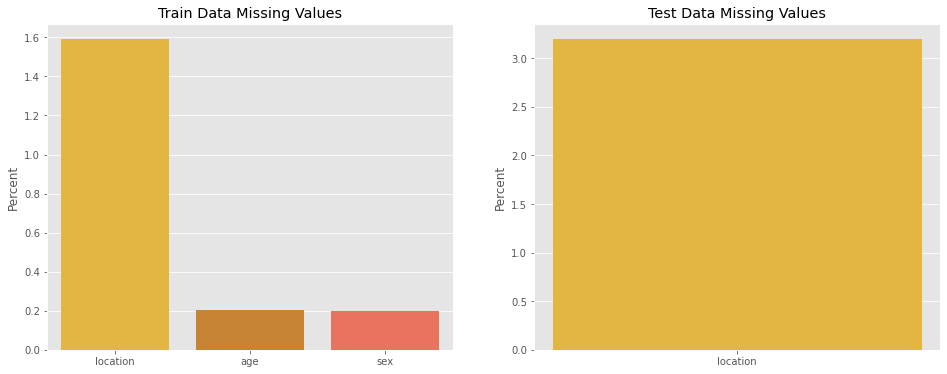

In [10]:
# Checking missing values:

def missing_percentage(df):

    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


missing_train = missing_percentage(train)
missing_test = missing_percentage(test)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=missing_train.index,
            y='Percent',
            data=missing_train,
            palette=orange_black,
            ax=ax[0])

sns.barplot(x=missing_test.index,
            y='Percent',
            data=missing_test,
            palette=orange_black,
            ax=ax[1])

ax[0].set_title('Train Data Missing Values')
ax[1].set_title('Test Data Missing Values')

## Checking Variables Before Imputing

Just wanted to check variable distribution before we impute the missing ones. Looks like our assumptions were ok, we can continue with imputing...

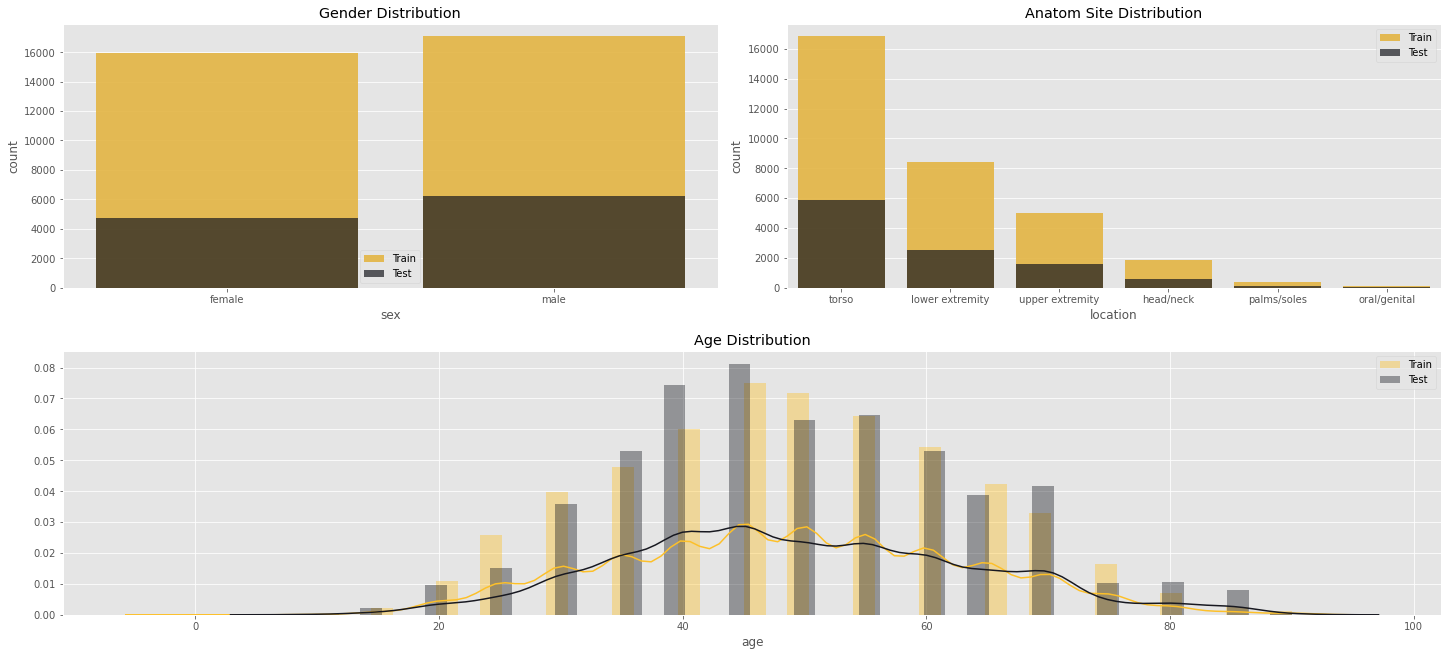

In [11]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 9))

# Creating a grid:

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Gender Distribution')

sns.countplot(train.sex.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax1,
              color='#fdc029',
              label='Train')
sns.countplot(test.sex.sort_values(ignore_index=True),
              alpha=0.7,
              ax=ax1,
              color='#171820',
              label='Test')
ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Plot the countplot.

sns.countplot(train.location,
              alpha=0.9,
              ax=ax2,
              color='#fdc029',
              label='Train',
              order=train['location'].value_counts().index)
sns.countplot(test.location,
              alpha=0.7,
              ax=ax2,
              color='#171820',
              label='Test',
              order=test['location'].value_counts().index), ax2.set_title(
                  'Anatom Site Distribution')

ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Age Distribution')

# Plot the histogram.

sns.distplot(train.age, ax=ax3, label='Train', color='#fdc029')
sns.distplot(test.age, ax=ax3, label='Test', color='#171820')

ax3.legend()

plt.show()

# Imputing Missing Data

Let's fill the missing values with appropriate methods.

In [12]:
# Filling missing anatom site values with 'unknown' tag:

for df in [train, test]:
    df['location'].fillna('unknown', inplace=True)

In [13]:
# Double checking:

ids_train = train.location.values
ids_test = test.location.values
ids_train_set = set(ids_train)
ids_test_set = set(ids_test)

location_not_overlap = list(ids_train_set.symmetric_difference(ids_test_set))
n_overlap = len(location_not_overlap)
if n_overlap == 0:
    print(
        f'There are no different body parts occuring between train and test set...'
    )
else:
    print('There are some not overlapping values between train and test set!')

There are no different body parts occuring between train and test set...


In [14]:
# Filling age and sex with appropriate values.

train['sex'].fillna(train['sex'].mode()[0], inplace=True)

train['age'].fillna(train['age'].median(), inplace=True)

In [15]:
# Checking missing value counts:

print(
    f'Train missing value count: {train.isnull().sum().sum()}\nTest missing value count: {train.isnull().sum().sum()}'
)

Train missing value count: 0
Test missing value count: 0


# Exploring the Data

## Scans by Anatom Site

Good... It looks like both datasets shared scanned body parts similary. Let's check it further.

In [16]:
# Train data:

cntstr = train.location.value_counts().rename_axis('location').reset_index(
    name='count')

fig = px.treemap(cntstr,
                 path=['location'],
                 values='count',
                 color='count',
                 color_continuous_scale=orange_black,
                 title='Scans by Anatom Site General Challenge - Train Data')

fig.update_traces(textinfo='label+percent entry')
fig.show()

In [17]:
# Test data:

cntste = test.location.value_counts().rename_axis('location').reset_index(
    name='count')

fig = px.treemap(cntste,
                 path=['location'],
                 values='count',
                 color='count',
                 color_continuous_scale=orange_black,
                 title='Scans by Anatom Site General Challenge - Test Data')

fig.update_traces(textinfo='label+percent entry')
fig.show()

# Body Part Ratio by Gender and Target

Looks like some body parts are more likely to be malignant, head/neck comes first with followed by oral/genital and upper extremity. Scanned body part locations are similar in order between males and females with small differences on distribution.

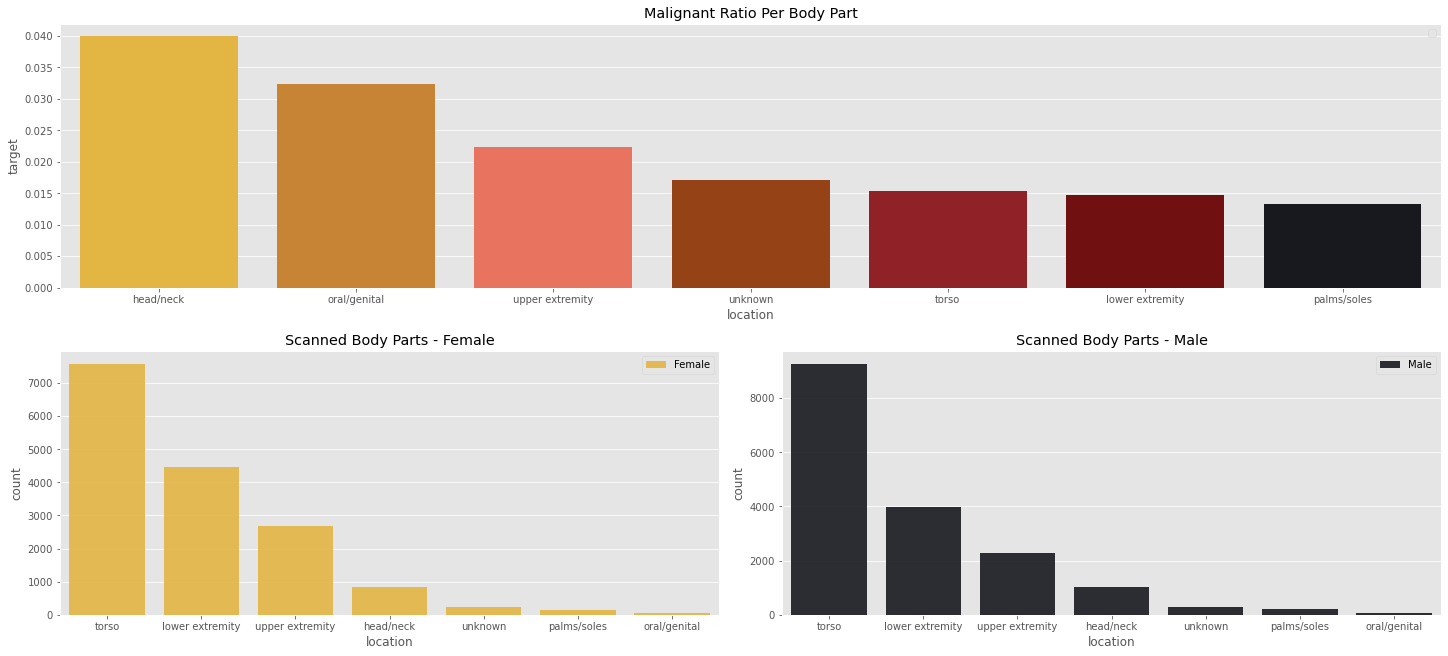

In [18]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 9))
# Creating a grid
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[1, :2])
# Set the title.
ax1.set_title('Scanned Body Parts - Female')

# Plot:

sns.countplot(
    train[train['sex'] == 'female'].location.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax1,
    color='#fdc029',
    label='Female',
    order=train['location'].value_counts().index)
ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[1, 2:])

# Set the title.

ax2.set_title('Scanned Body Parts - Male')

# Plot.

sns.countplot(
    train[train['sex'] == 'male'].location.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax2,
    color='#171820',
    label='Male',
    order=train['location'].value_counts().index)

ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[0, :])

# Set the title.

ax3.set_title('Malignant Ratio Per Body Part')

# Plot.

loc_freq = train.groupby('location')['target'].mean().sort_values(
    ascending=False)
sns.barplot(x=loc_freq.index, y=loc_freq, palette=orange_black, ax=ax3)

ax3.legend()

plt.show()

# A General Look With Sunburst Chart

Sunburst chart is pretty cool looking fella I'd say. It also giving lots of basic information to us. Let's see...

- Only 2% of our targets are malignant
- On malignant images males are dominant with 62% 
- Gender wise benign images are more balance 52-48% male female ratio
- Malignant image scan locations differs based on the patients gender:
    - Meanwhile the torso is most common location in males it's almost half of the scans meanwhile in females it's 39%
    - Lower extremity is more common with female scans than males 18% males vs 26% females
    - Again upper extremity malignant scans is common with females than males (23- 17%)
- Benign image scan locations more similar between male and female patients.

In [19]:
# Plotting interactive sunburst:

fig = px.sunburst(data_frame=train,
                  path=['benign_malignant', 'sex', 'location'],
                  color='sex',
                  color_discrete_sequence=orange_black,
                  maxdepth=-1,
                  title='Sunburst Chart Benign/Malignant > Sex > Location')

fig.update_traces(textinfo='label+percent parent')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

# Age and Scan Result Relations

Age looks pretty decent factor on scan result. Getting malignant scan result with elderly age is more possible than young patients. There is spike for both genders after age of 85, if we look distribution of ages there isn't much of 80+ patients and it can be the reason of this spike but we can safely say it's more likely to be malignant scan after age of 60. We see small bump on age 15-20 for females, again it depends on the scan numbers but still, poor souls...

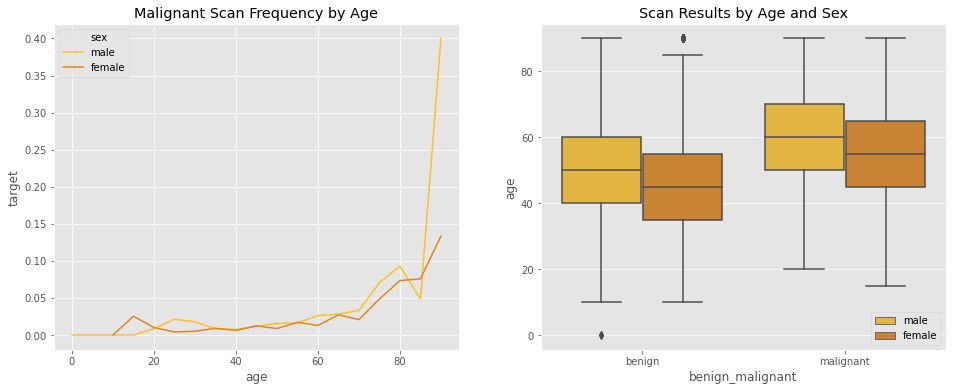

In [20]:
# Plotting age vs sex vs target:

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(x='age',
             y='target',
             data=train,
             ax=ax[0],
             hue='sex',
             palette=orange_black[:2],
             ci=None)
sns.boxplot(x='benign_malignant',
            y='age',
            data=train,
            ax=ax[1],
            hue='sex',
            palette=orange_black)

plt.legend(loc='lower right')

ax[0].set_title('Malignant Scan Frequency by Age')
ax[1].set_title('Scan Results by Age and Sex')

plt.show()

# Age Round Two

Wanted to double check age distributions after our previous observations. Age seems evenly distributed on both train and test datasets, we can see small bumps at age 75+ and around 40, these worth investigating.

We can see again older people are more likely to get malignant scan results. One last thing about age distributions, we see more female patients in younger ages this trend changes with the older patients...

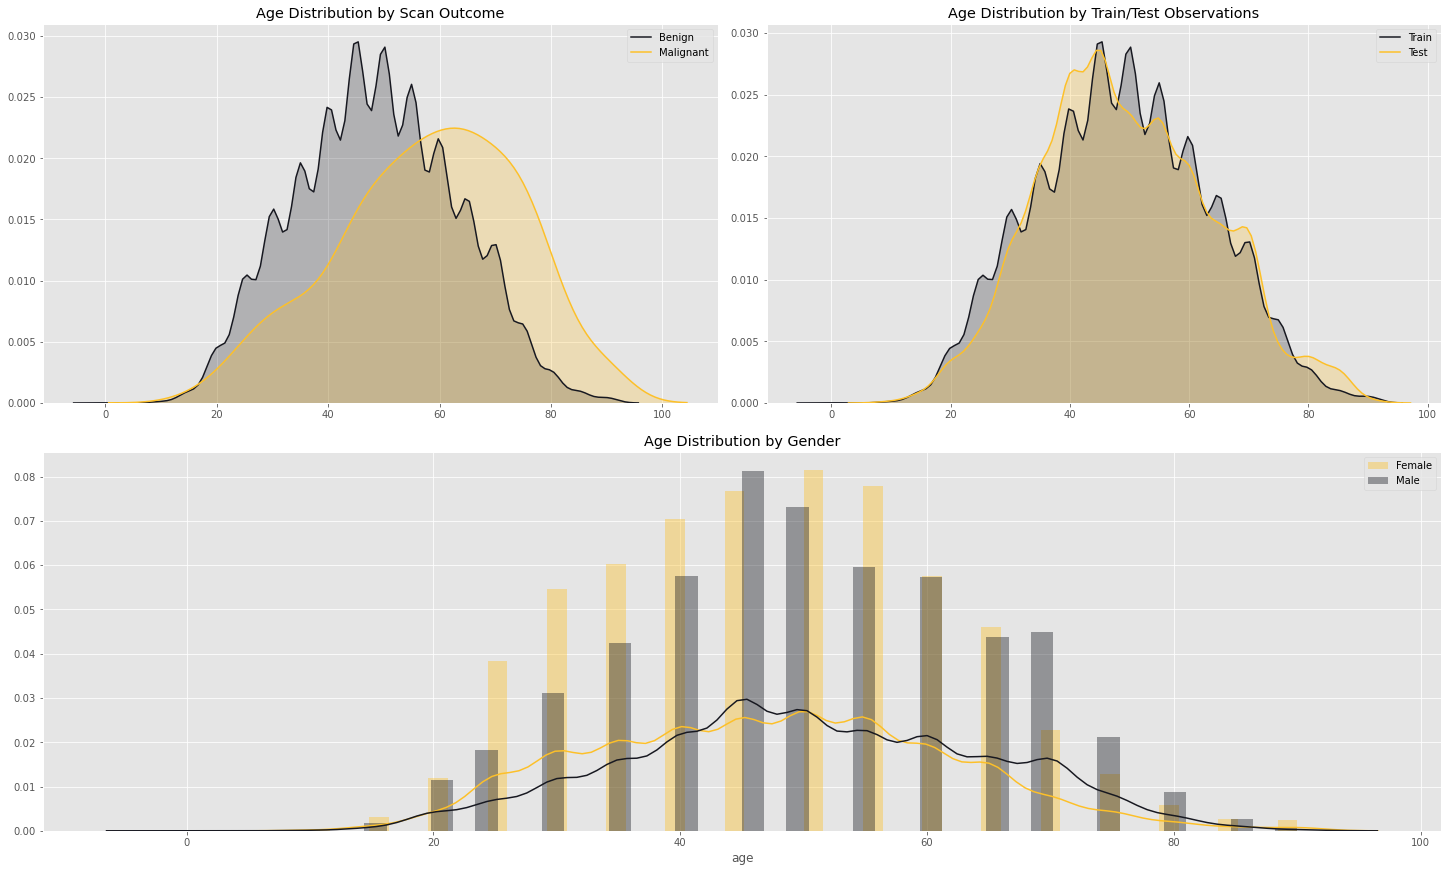

In [21]:
# Creating a customized chart and giving in figsize etc.

# Plotting age dist vs target and age dist vs datasets

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Age Distribution by Scan Outcome')

# Plot

ax1.legend()

sns.kdeplot(train[train['target'] == 0]['age'],
            shade=True,
            ax=ax1,
            color='#171820',
            label='Benign')
sns.kdeplot(train[train['target'] == 1]['age'],
            shade=True,
            ax=ax1,
            color='#fdc029',
            label='Malignant')

# Customizing second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Set the title.

ax2.set_title('Age Distribution by Train/Test Observations')

# Plot.

sns.kdeplot(train.age, label='Train', shade=True, ax=ax2, color='#171820')
sns.kdeplot(test.age, label='Test', shade=True, ax=ax2, color='#fdc029')

ax2.legend()

# Customizing third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Age Distribution by Gender')

# Plot

sns.distplot(train[train.sex == 'female'].age,
             ax=ax3,
             label='Female',
             color='#fdc029')
sns.distplot(train[train.sex == 'male'].age,
             ax=ax3,
             label='Male',
             color='#171820')
ax3.legend()

plt.show()

# Unique Patients and Their Scan Images

It looks like we have multiple scan images per patient, actual unique patient counts are much lower than images on both datasets. We can get more information about patients age like when he had his first scan and his last scan. We can get interesting insights like:

- Most of the malignant results are found around first 20 scans. Of course there can be control scans after the diagnosis...
- Scan numbers are similar in first 100 scans but we have 200+ scan images for **one particular patient** in dataset, it's pretty interesting since we don't have this case in our training data. We should be careful about this and it can effect our model.
- Most of the malignant cases are under 20 images but in general we can say it's more likely to be malignant result if there are more scan images...

In [22]:
print(
    f'Number of unique Patient ID\'s in train set: {train.id.nunique()}, Total: {train.id.count()}\nNumber of unique Patient ID\'s in test set: {test.id.nunique()}, Total: {test.id.count()}'
)

Number of unique Patient ID's in train set: 2056, Total: 33126
Number of unique Patient ID's in test set: 690, Total: 10982


In [23]:
train['age_min'] = train['id'].map(train.groupby(['id']).age.min())
train['age_max'] = train['id'].map(train.groupby(['id']).age.max())

test['age_min'] = test['id'].map(test.groupby(['id']).age.min())
test['age_max'] = test['id'].map(test.groupby(['id']).age.max())

In [24]:
train['n_images'] = train.id.map(train.groupby(['id']).img_name.count())
test['n_images'] = test.id.map(test.groupby(['id']).img_name.count())

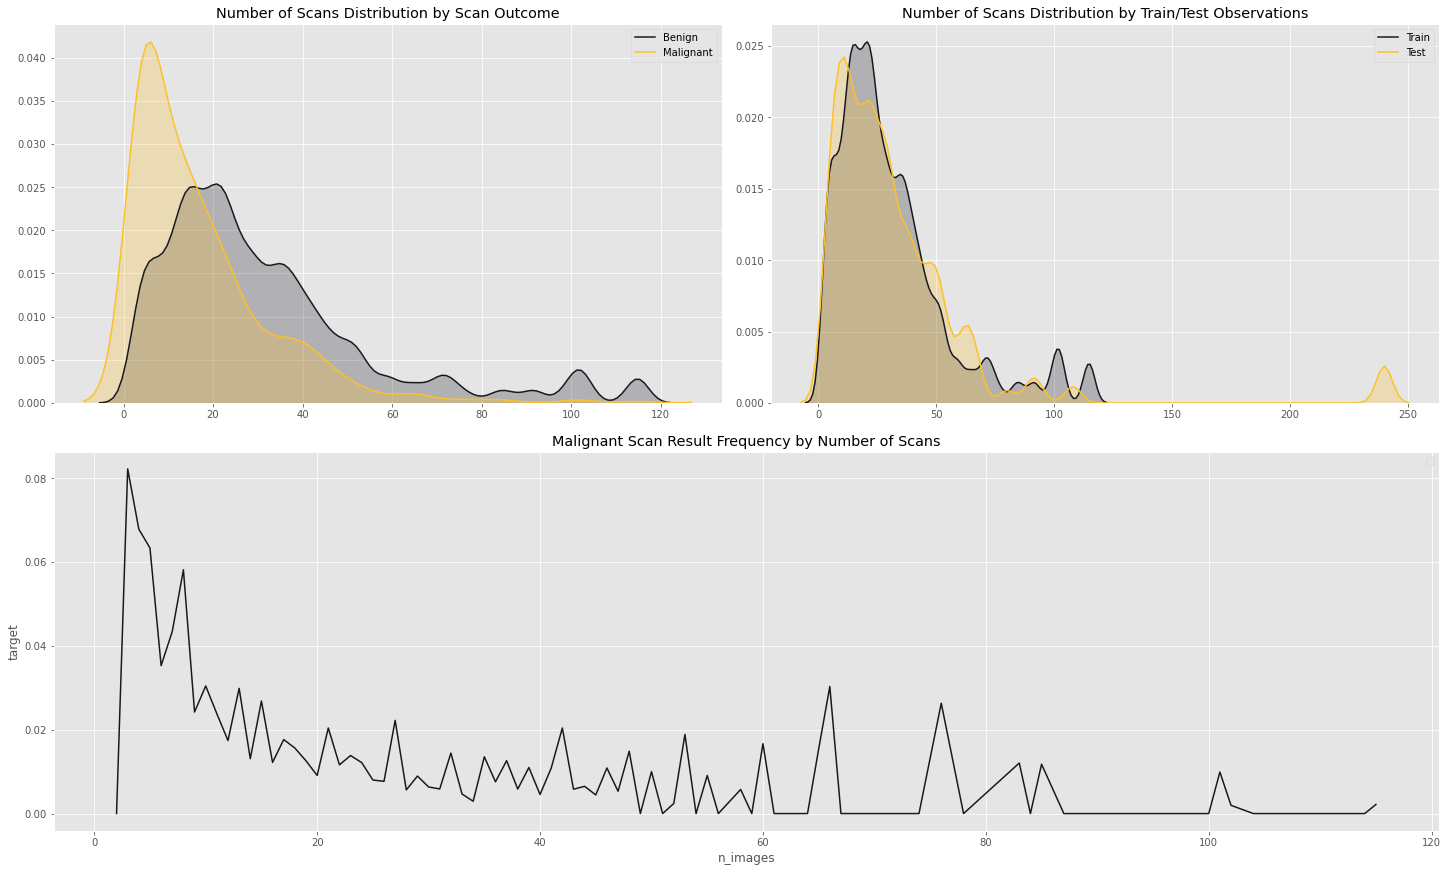

In [25]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Number of Scans Distribution by Scan Outcome')

# Plot

sns.kdeplot(train[train['target'] == 0]['n_images'],
            shade=True,
            ax=ax1,
            color='#171820',
            label='Benign')
sns.kdeplot(train[train['target'] == 1]['n_images'],
            shade=True,
            ax=ax1,
            color='#fdc029',
            label='Malignant')

ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Set the title.

ax2.set_title('Number of Scans Distribution by Train/Test Observations')

# Plot

sns.kdeplot(train.n_images, label='Train', shade=True, ax=ax2, color='#171820')
sns.kdeplot(test.n_images, label='Test', shade=True, ax=ax2, color='#fdc029')
ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Malignant Scan Result Frequency by Number of Scans')

# Plot

z = train.groupby('n_images')['target'].mean()
sns.lineplot(x=z.index, y=z, color='#171820', ax=ax3)
ax3.legend()

plt.show()

# Diagnosis Distribution

This part we can't use in our model but it's giving us some insights about this disease so we can inspect that too. You can see the details below:

In [26]:
diag = train.diagnosis.value_counts()
fig = px.pie(diag,
             values='diagnosis',
             names=diag.index,
             color_discrete_sequence=orange_black,
             hole=.4)
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

# Loading Image Meta Features

This is the part where we get basic info directly from images themselves.

In [27]:
# Getting image sizes by using os:

for data, location in zip([train, test], [train_img_path, test_img_path]):
    images = data['img_name'].values
    sizes = np.zeros(images.shape[0])
    for i, path in enumerate(tqdm(images)):
        sizes[i] = os.path.getsize(os.path.join(location, f'{path}.jpg'))

    data['image_size'] = sizes

100%|██████████| 10982/10982 [00:03<00:00, 2844.33it/s]


# Image Sizes

We can see some kind of relation between size and target, but is it meaningful? Too soon to say...

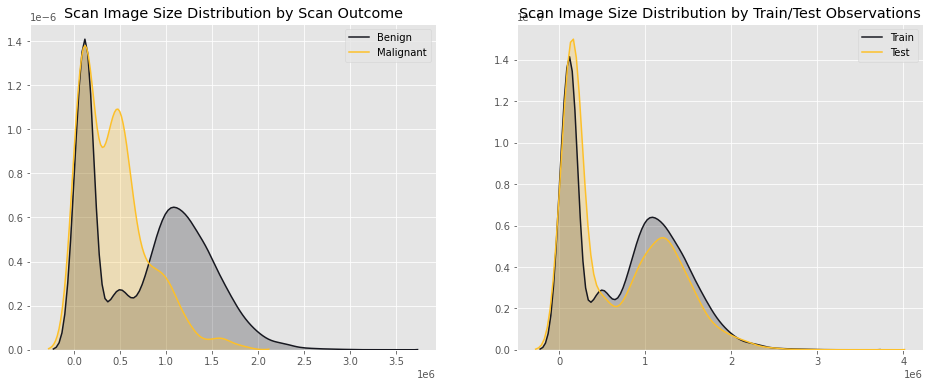

In [28]:
# Plotting image sizes:

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(train[train['target'] == 0]['image_size'],
            shade=True,
            ax=ax[0],
            color='#171820',
            label='Benign')
sns.kdeplot(train[train['target'] == 1]['image_size'],
            shade=True,
            ax=ax[0],
            color='#fdc029',
            label='Malignant')

sns.kdeplot(train.image_size,
            label='Train',
            shade=True,
            ax=ax[1],
            color='#171820')
sns.kdeplot(test.image_size,
            label='Test',
            shade=True,
            ax=ax[1],
            color='#fdc029')

ax[0].set_title('Scan Image Size Distribution by Scan Outcome')
ax[1].set_title('Scan Image Size Distribution by Train/Test Observations')

plt.show()

## Getting Image Attributes

You can get these attributes by using the code below, I commented it out here and imported it as a data becasue it's time consuming process.

In [29]:
#from keras.preprocessing import image
#
# for data, location in zip([train, test],[train_img_path, test_img_path]):
#    images = data['img_name'].values
#    reds = np.zeros(images.shape[0])
#    greens = np.zeros(images.shape[0])
#    blues = np.zeros(images.shape[0])
#    mean = np.zeros(images.shape[0])
#    x = np.zeros(images.shape[0], dtype=int)
#    y = np.zeros(images.shape[0], dtype=int)
#    for i, path in enumerate(tqdm(images)):
#        img = np.array(image.load_img(os.path.join(location, f'{path}.jpg')))
#
#        reds[i] = np.mean(img[:,:,0].ravel())
#        greens[i] = np.mean(img[:,:,1].ravel())
#        blues[i] = np.mean(img[:,:,2].ravel())
#        mean[i] = np.mean(img)
#        x[i] = img.shape[1]
#        y[i] = img.shape[0]
#
#    data['reds'] = reds
#    data['greens'] = greens
#    data['blues'] = blues
#    data['mean_colors'] = mean
#    data['width'] = x
#    data['height'] = y
#
#train['total_pixels']= train['width']*train['height']
#test['total_pixels']= test['width']*test['height']
#train['res'] = train['width'].astype(str) + 'x' + train['height'].astype(str)
#test['res'] = test['width'].astype(str) + 'x' + test['height'].astype(str)

In [30]:
# Loading color data:

train_attr = pd.read_csv(
    os.path.join(img_stats_path, 'train_mean_colorres.csv'))
test_attr = pd.read_csv(os.path.join(img_stats_path, 'test_mean_colorres.csv'))

In [31]:
train_attr.head()

,reds,greens,blues,mean_colors,width,height,total_pixels
0,212.935898,138.914175,157.742255,169.864109,6000,4000,24000000
1,217.292550,165.093667,130.881285,171.089167,6000,4000,24000000
2,199.941121,130.227057,145.908743,158.692307,1872,1053,1971216
3,119.690968,62.614725,58.724976,80.343556,1872,1053,1971216
4,226.279244,173.174914,152.425131,183.959763,6000,4000,24000000


In [32]:
train = pd.concat([train, train_attr], axis=1)
test = pd.concat([test, test_attr], axis=1)

train['res'] = train['width'].astype(str) + 'x' + train['height'].astype(str)
test['res'] = test['width'].astype(str) + 'x' + test['height'].astype(str)

# Image Colors and Their Effects on Results

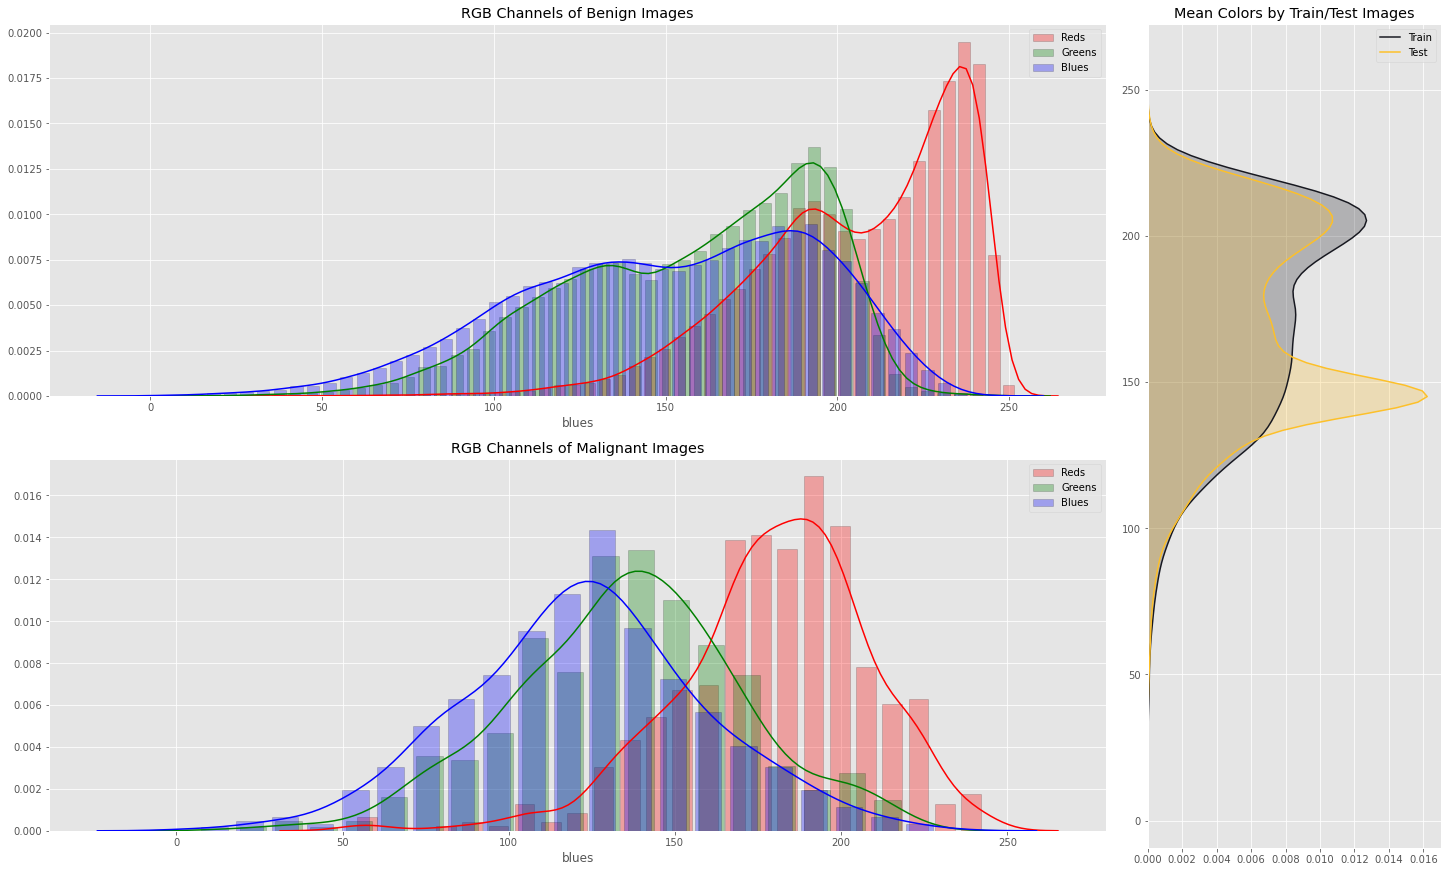

In [33]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('RGB Channels of Benign Images')

# Plot.

sns.distplot(train[train['target'] == 0].reds,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='red',
             kde=True,
             ax=ax1,
             label='Reds')
sns.distplot(train[train['target'] == 0].greens,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='green',
             kde=True,
             ax=ax1,
             label='Greens')
sns.distplot(train[train['target'] == 0].blues,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='blue',
             kde=True,
             ax=ax1,
             label='Blues')

ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[1, :2])

# Set the title.

ax2.set_title('RGB Channels of Malignant Images')

# Plot

sns.distplot(train[train['target'] == 1].reds,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='red',
             kde=True,
             ax=ax2,
             label='Reds')
sns.distplot(train[train['target'] == 1].greens,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='green',
             kde=True,
             ax=ax2,
             label='Greens')
sns.distplot(train[train['target'] == 1].blues,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='blue',
             kde=True,
             ax=ax2,
             label='Blues')
ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[:, 2])

# Set the title.

ax3.set_title('Mean Colors by Train/Test Images')

# Plot

sns.kdeplot(train.mean_colors,
            shade=True,
            label='Train',
            ax=ax3,
            color='#171820',
            vertical=True)
sns.kdeplot(test.mean_colors,
            shade=True,
            label='Test',
            ax=ax3,
            color='#fdc029',
            vertical=True)
ax3.legend()

plt.show()

# How are the Image Sizes Affecting Targets in Our Data

We have important observation here, you can see whole 1920x1080 set in test data which is not present in train data. That can have huge impact on final scores, mind that in your models. You might want to leave out image size related info in your models or regularize your models to smooth that effect. It can cause overfitting because of high correlation between image sizes and target, but these correlation might not be the case in test set (most likely) so keep that in mind.

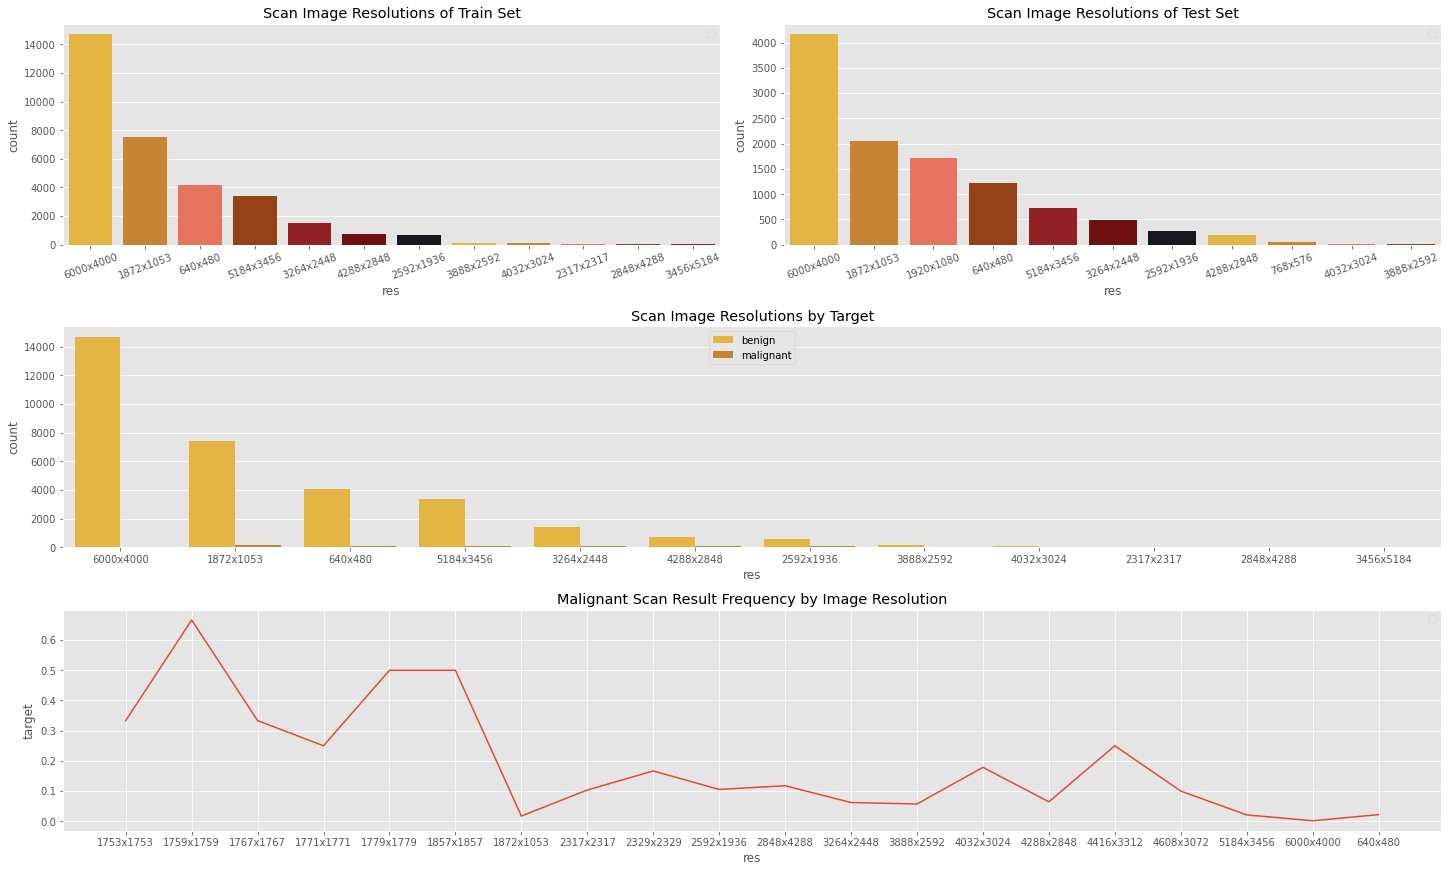

In [34]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=4, nrows=3, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Scan Image Resolutions of Train Set')

# Plot.

tres = train.res.value_counts().rename_axis('res').reset_index(name='count')
tres = tres[tres['count'] > 10]
sns.barplot(x='res', y='count', data=tres, palette=orange_black, ax=ax1)
plt.xticks(rotation=20)

ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Set the title.

ax2.set_title('Scan Image Resolutions of Test Set')

# Plot

teres = test.res.value_counts().rename_axis('res').reset_index(name='count')
teres = teres[teres['count'] > 10]
sns.barplot(x='res', y='count', data=teres, palette=orange_black, ax=ax2)
plt.xticks(rotation=20)
ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Scan Image Resolutions by Target')

# Plot.

sns.countplot(x='res',
              hue='benign_malignant',
              data=train,
              order=train.res.value_counts().iloc[:12].index,
              palette=orange_black,
              ax=ax3)
ax3.legend()

# Customizing the last grid.

ax4 = fig.add_subplot(grid[2, :])

# Set the title.

ax4.set_title('Malignant Scan Result Frequency by Image Resolution')

# Plot.

res_freq = train.groupby('res')['target'].mean()
res_freq = res_freq[(res_freq > 0) & (res_freq < 1)]
sns.lineplot(x=res_freq.index, y=res_freq, palette=orange_black, ax=ax4)
ax4.legend()

plt.show()

# The Mysterious Images

The name 'Mystery' comes from Chris Deotte from the comments down below and I decided to investigate them further. In last part we found out a new set of images with the resolution of 1920x1080 and they aren't present in train data at all. So we can assume these images weren't selected randomly for this competition. Down below I'm going to compare them with the rest of data.

* It looks like without the 1920x1080 set mean colors are much more similar between train and test.
* Again image size distribution gets closer between train and test without the mystery set.


Gonna check other features and add them here soon...

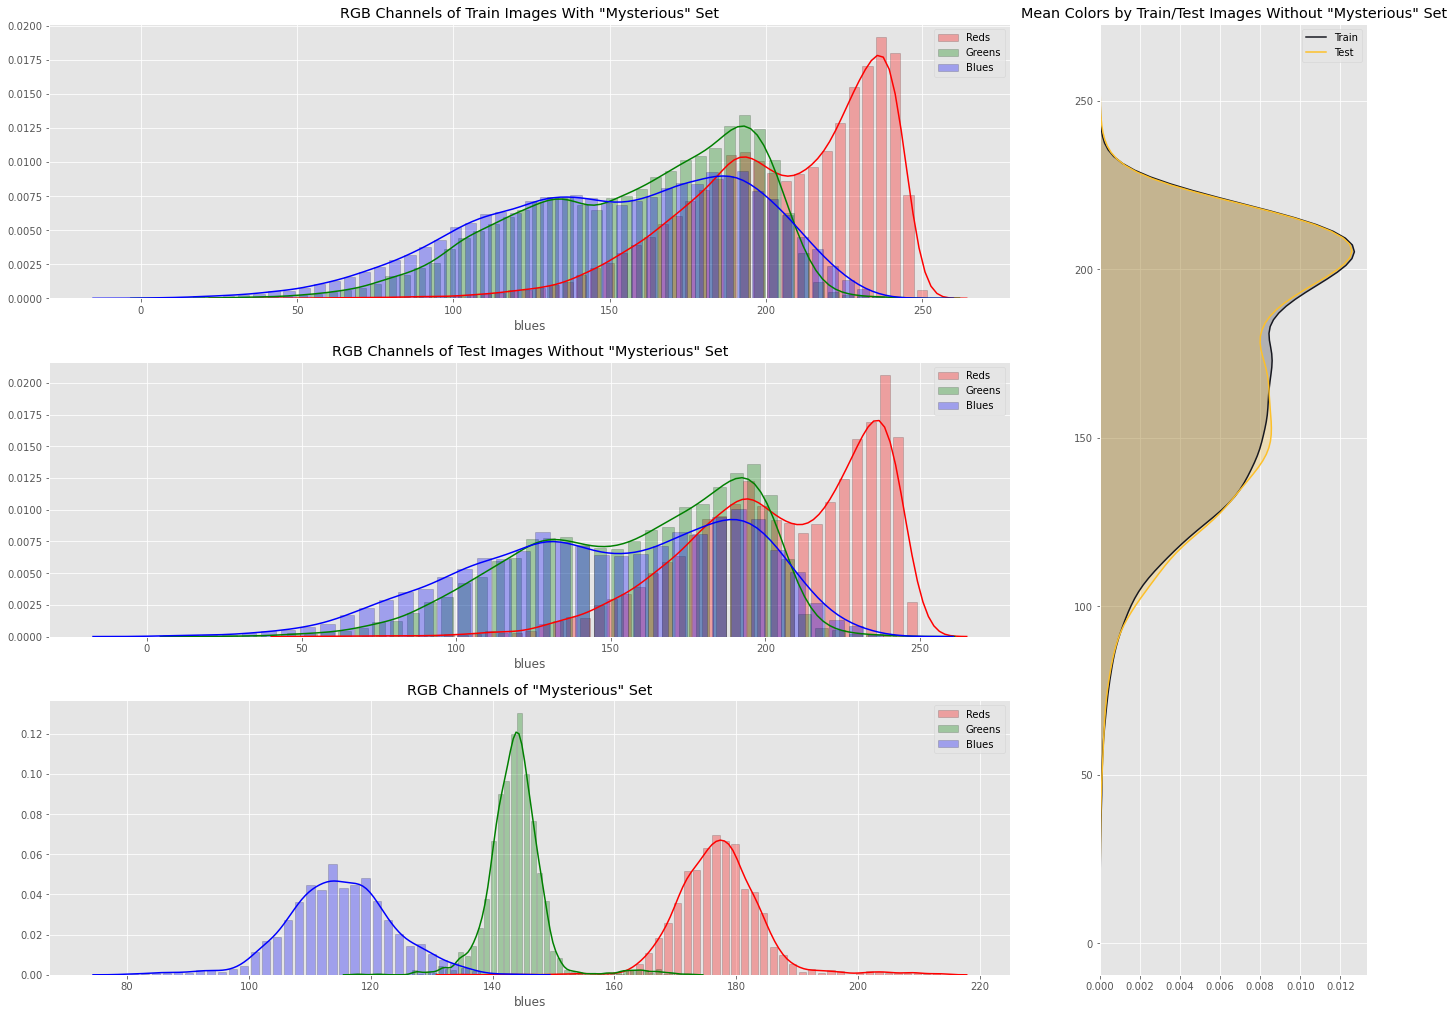

In [35]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 14))

# Creating a grid

grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('RGB Channels of Train Images With "Mysterious" Set')

# Plot.

sns.distplot(train.reds,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='red',
             kde=True,
             ax=ax1,
             label='Reds')
sns.distplot(train.greens,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='green',
             kde=True,
             ax=ax1,
             label='Greens')
sns.distplot(train.blues,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='blue',
             kde=True,
             ax=ax1,
             label='Blues')

ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[1, :2])

# Set the title.

ax2.set_title('RGB Channels of Test Images Without "Mysterious" Set')

# Plot

sns.distplot(test[test['res'] != '1920x1080'].reds,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='red',
             kde=True,
             ax=ax2,
             label='Reds')
sns.distplot(test[test['res'] != '1920x1080'].greens,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='green',
             kde=True,
             ax=ax2,
             label='Greens')
sns.distplot(test[test['res'] != '1920x1080'].blues,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='blue',
             kde=True,
             ax=ax2,
             label='Blues')
ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[:, 2])

# Set the title.

ax3.set_title('Mean Colors by Train/Test Images Without "Mysterious" Set')

# Plot

sns.kdeplot(train.mean_colors,
            shade=True,
            label='Train',
            ax=ax3,
            color='#171820',
            vertical=True)
sns.kdeplot(test[test['res'] != '1920x1080'].mean_colors,
            shade=True,
            label='Test',
            ax=ax3,
            color='#fdc029',
            vertical=True)
ax3.legend()

# Customizing the last grid.

ax2 = fig.add_subplot(grid[2, :2])

# Set the title.

ax2.set_title('RGB Channels of "Mysterious" Set')

# Plot

sns.distplot(test[test['res'] == '1920x1080'].reds,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='red',
             kde=True,
             ax=ax2,
             label='Reds')
sns.distplot(test[test['res'] == '1920x1080'].greens,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='green',
             kde=True,
             ax=ax2,
             label='Greens')
sns.distplot(test[test['res'] == '1920x1080'].blues,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='blue',
             kde=True,
             ax=ax2,
             label='Blues')
ax2.legend()

plt.show()

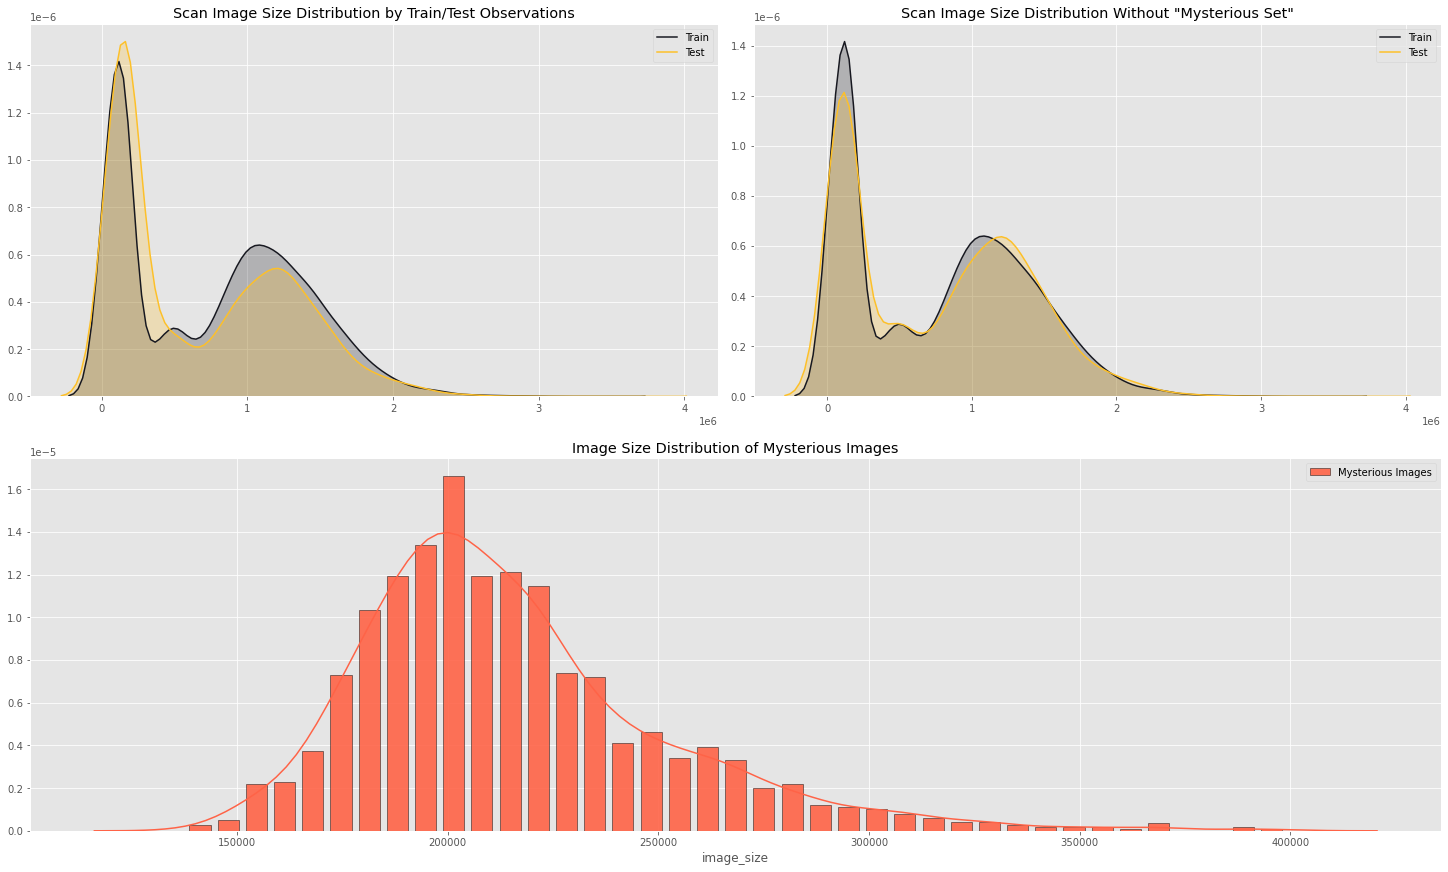

In [36]:
# Creating a customized chart and giving in figsize etc.

# Plotting age dist vs target and age dist vs datasets

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Scan Image Size Distribution by Train/Test Observations')

# Plot

ax1.legend()

sns.kdeplot(train['image_size'],
            shade=True,
            ax=ax1,
            color='#171820',
            label='Train')
sns.kdeplot(test['image_size'],
            shade=True,
            ax=ax1,
            color='#fdc029',
            label='Test')

# Customizing second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Set the title.

ax2.set_title('Scan Image Size Distribution Without "Mysterious Set"')

# Plot.

sns.kdeplot(train.image_size,
            label='Train',
            shade=True,
            ax=ax2,
            color='#171820')
sns.kdeplot(test[test['res'] != '1920x1080'].image_size,
            label='Test',
            shade=True,
            ax=ax2,
            color='#fdc029')
ax2.legend()

# Customizing third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Image Size Distribution of Mysterious Images')

# Plot

sns.distplot(test[test['res'] == '1920x1080'].image_size,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.9
             },
             color='#FF6347',
             kde=True,
             ax=ax3,
             label='Mysterious Images')
ax3.legend()

plt.show()

I was curious about if these 1920x1080 images belong to high scan patients including 200+ one but it seems these observations are grouped around 10 scans, so it makes things more interesting...

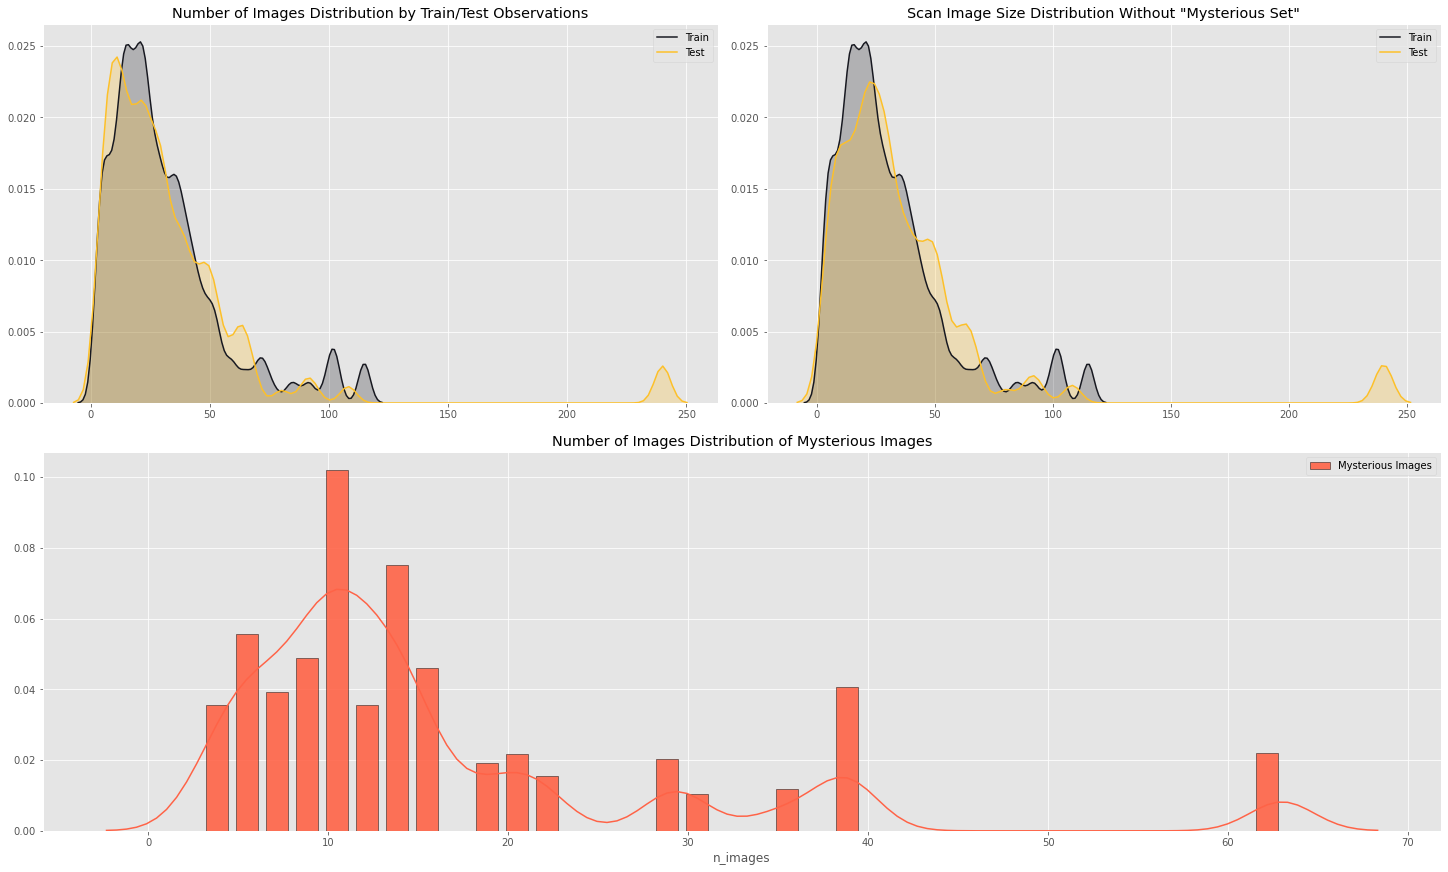

In [37]:
# Creating a customized chart and giving in figsize etc.

# Plotting age dist vs target and age dist vs datasets

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Number of Images Distribution by Train/Test Observations')

# Plot

ax1.legend()

sns.kdeplot(train['n_images'],
            shade=True,
            ax=ax1,
            color='#171820',
            label='Train')
sns.kdeplot(test['n_images'],
            shade=True,
            ax=ax1,
            color='#fdc029',
            label='Test')

# Customizing second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Set the title.

ax2.set_title('Scan Image Size Distribution Without "Mysterious Set"')

# Plot.

sns.kdeplot(train.n_images,
            label='Train',
            shade=True,
            ax=ax2,
            color='#171820')
sns.kdeplot(test[test['res'] != '1920x1080'].n_images,
            label='Test',
            shade=True,
            ax=ax2,
            color='#fdc029')
ax2.legend()

# Customizing third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Number of Images Distribution of Mysterious Images')

# Plot

sns.distplot(test[test['res'] == '1920x1080'].n_images,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.9
             },
             color='#FF6347',
             kde=True,
             ax=ax3,
             label='Mysterious Images')
ax3.legend()

plt.show()

Since we checking this mystery patch of images, let's check other features about them too maybe we can find other factors effecting this test sampling...

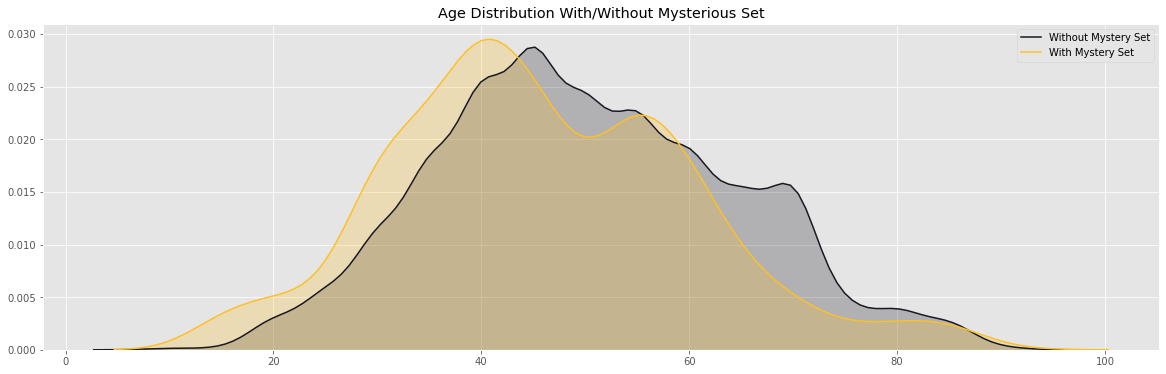

In [38]:
fig, ax = plt.subplots(figsize=(20, 6))

sns.kdeplot(test[test['res'] != '1920x1080'].age,
            shade=True,
            label='Without Mystery Set',
            color='#171820',
            )
sns.kdeplot(test[test['res'] == '1920x1080'].age,
            shade=True,
            label='With Mystery Set',
            color='#fdc029',
            )

plt.legend(loc='upper right')

ax.set_title('Age Distribution With/Without Mysterious Set')


plt.show()

Looks like our 1920x1080 set images consisting little bit younger patients than the rest. Interesting...

# Visual Inspection of Mysterious Image Set

This is subjective, but when we look at both samples we can see that 1920x1080 images are coming from a 'imaging device' with black circle around the images? In general this isn't the case with the rest of the test image samples... Maybe we can use similar images from previous competitions for predicting this set? I don't know yet but worth to consider I guess...

In [39]:
mystery = test[test['res'] == '1920x1080']
mystimages = mystery['img_name'].values

nonmystery = test[test['res'] != '1920x1080']
nonmystimages = nonmystery['img_name'].values

random_myst_images = [np.random.choice(mystimages+'.jpg') for i in range(12)]
random_nmyst_images = [np.random.choice(nonmystimages+'.jpg') for i in range(12)]

# Location of test images
img_dir = '../input/siim-isic-melanoma-classification/jpeg/test'

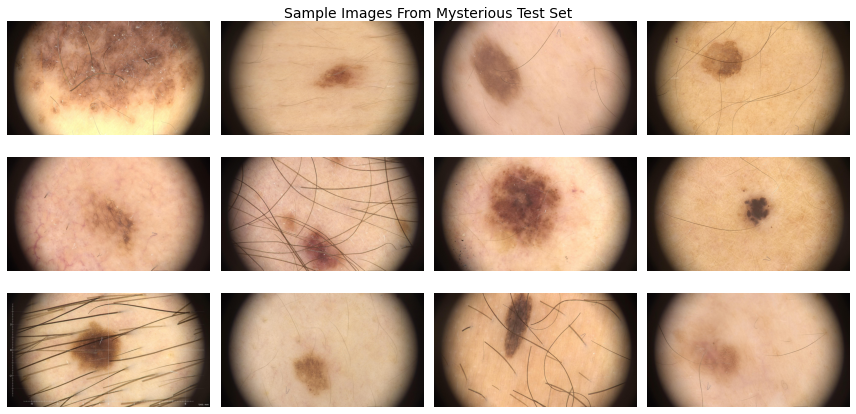

In [40]:
plt.figure(figsize=(12,6))
for i in range(12):
    
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(img_dir, random_myst_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.suptitle('Sample Images From Mysterious Test Set', fontsize=14)
plt.tight_layout()   
  

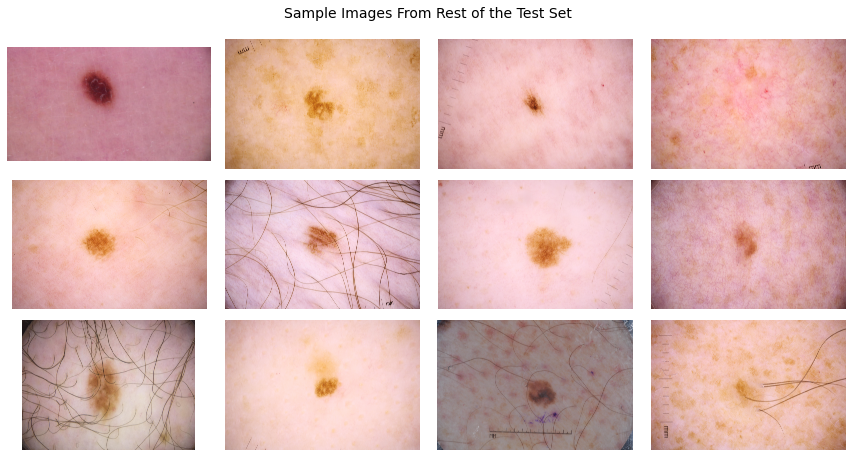

In [41]:
plt.figure(figsize=(12,6))
for i in range(12):
    
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(img_dir, random_nmyst_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off') 
    
plt.suptitle('Sample Images From Rest of the Test Set', fontsize=14, y=1.05)
plt.tight_layout()   

# Correlations Between Features

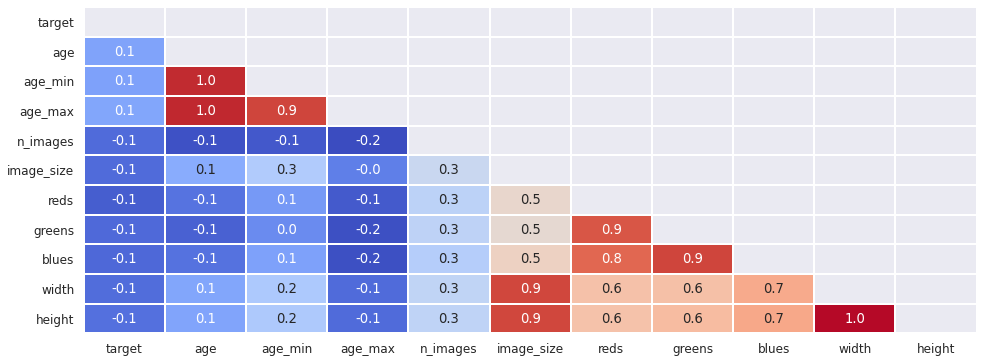

In [42]:
# Display numerical correlations between features on heatmap.

sns.set(font_scale=1.1)
correlation_train = train[['target','age','age_min',
 'age_max',
 'n_images',
 'image_size',
 'reds',
 'greens',
 'blues', 
 'width',
 'height',
 ]].corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(16, 6))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',            
            mask=mask,
            linewidths=1,
            cbar=False)

plt.show()



# Modelling Based on Tabular Meta Features

## Getting Landscape Attributes from Images

Thanks to this great dataset by Marcelo Kittlein [here.](https://www.kaggle.com/kittlein/landscape)

In [43]:
# Loading lanscape data

train40 = pd.read_csv('../input/melanoma2020imgtabular/train40Features.csv')
test40 = pd.read_csv('../input/melanoma2020imgtabular/test40Features.csv')

trainmet = pd.read_csv('../input/melanoma2020imgtabular/trainMetrics.csv')
testmet = pd.read_csv('../input/melanoma2020imgtabular/testMetrics.csv')

In [44]:
# Dropping duplicate data from lanscape dataset

train40.drop(['sex', 'age_approx', 'anatom_site_general_challenge'],
             axis=1,
             inplace=True)

test40.drop(['sex', 'age_approx', 'anatom_site_general_challenge'],
            axis=1,
            inplace=True)

In [45]:
# merging both datasets

train = pd.concat([train, train40, trainmet], axis=1)
test = pd.concat([test, test40, testmet], axis=1)

In [46]:
# checking out new dataset

train.head()

,img_name,id,sex,age,location,diagnosis,benign_malignant,target,age_min,age_max,...,X368,X369,X370,X371,X373,X374,X375,X376,X377,X378
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,45.0,45.0,...,87.890625,0.36338,0.958659,0.000088,1.0,0.382456,1,4.0,4.0,1.0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,45.0,45.0,...,87.890625,0.36338,0.958659,0.000088,1.0,0.382456,1,4.0,4.0,1.0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,50.0,55.0,...,87.890625,0.36338,0.958659,0.000088,1.0,0.382456,1,4.0,4.0,1.0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,40.0,45.0,...,87.890625,0.36338,0.958659,0.000088,1.0,0.382456,1,4.0,4.0,1.0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,55.0,55.0,...,87.890625,0.36338,0.958659,0.000088,1.0,0.382456,1,4.0,4.0,1.0


# Getting Data Ready For ML Algorithms

In [47]:
# getting dummy variables for gender on train set

sex_dummies = pd.get_dummies(train['sex'], prefix='sex')
train = pd.concat([train, sex_dummies], axis=1)

# getting dummy variables for gender on test set

sex_dummies = pd.get_dummies(test['sex'], prefix='sex')
test = pd.concat([test, sex_dummies], axis=1)

# dropping not useful columns

train.drop(['sex','res','img_name','id','diagnosis','benign_malignant'], axis=1, inplace=True)
test.drop(['sex','res','img_name','id'], axis=1, inplace=True)

In [48]:
# getting dummy variables for location on train set

anatom_dummies = pd.get_dummies(train['location'], prefix='anatom')
train = pd.concat([train, anatom_dummies], axis=1)

# getting dummy variables for location on test set

anatom_dummies = pd.get_dummies(test['location'], prefix='anatom')
test = pd.concat([test, anatom_dummies], axis=1)

# dropping not useful columns

train.drop('location', axis=1, inplace=True)
test.drop('location', axis=1, inplace=True)

# Loading Modelling Tools

In [49]:
# loading modelling libraries

import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve

In [50]:
# dividing train set and labels for modelling

X = train.drop('target', axis=1)
y = train.target

## Setting Cross-Validation and Hold-out Set

Cross validation might be enough but I wanted to test our model on data which it never seen before.

In [51]:
# taking holdout set for validating with stratified y

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

# 5 fold stratify for cv

cv = StratifiedKFold(5, shuffle=True, random_state=42)

In [52]:
# setting model hyperparameters, didn't include fine tuning here because of timing reasons...

xg = xgb.XGBClassifier(
    n_estimators=750,
    min_child_weight=0.81,
    learning_rate=0.025,
    max_depth=2,
    subsample=0.80,
    colsample_bytree=0.42,
    gamma=0.10,
    random_state=42,
    n_jobs=-1,
)

In [53]:
estimators = [xg]

In [54]:
# cross validation scheme

def model_check(X_train, y_train, estimators, cv):
    model_table = pd.DataFrame()

    row_index = 0
    for est in estimators:

        MLA_name = est.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    scoring='roc_auc',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index,
                        'Train roc Mean'] = cv_results['train_score'].mean()
        model_table.loc[row_index,
                        'Test roc Mean'] = cv_results['test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test roc Mean'],
                            ascending=False,
                            inplace=True)

    return model_table

# Model Results Based on Meta Features

Results are encouraging! It seems little bit overfitting but we might fix that in future by fine tuning. Let's leave it like that for now...

In [55]:
# display cv results

raw_models = model_check(X_train, y_train, estimators, cv)
display(raw_models)

,Model Name,Train roc Mean,Test roc Mean,Test Std,Time
0,XGBClassifier,0.925061,0.864124,0.013974,83.842486


In [56]:
# fitting train data

xg.fit(X_train, y_train)

# predicting on holdout set
validation = xg.predict_proba(X_test)[:, 1]

# checking results on validation set
roc_auc_score(y_test, validation)

0.8732104003267008

# Meta Feature Importances

Image size seems pretty important on our model, but don't forget this can be misleading for final scoring. Don't forget about missing image sizes in test set and size correlation with targets in train data!

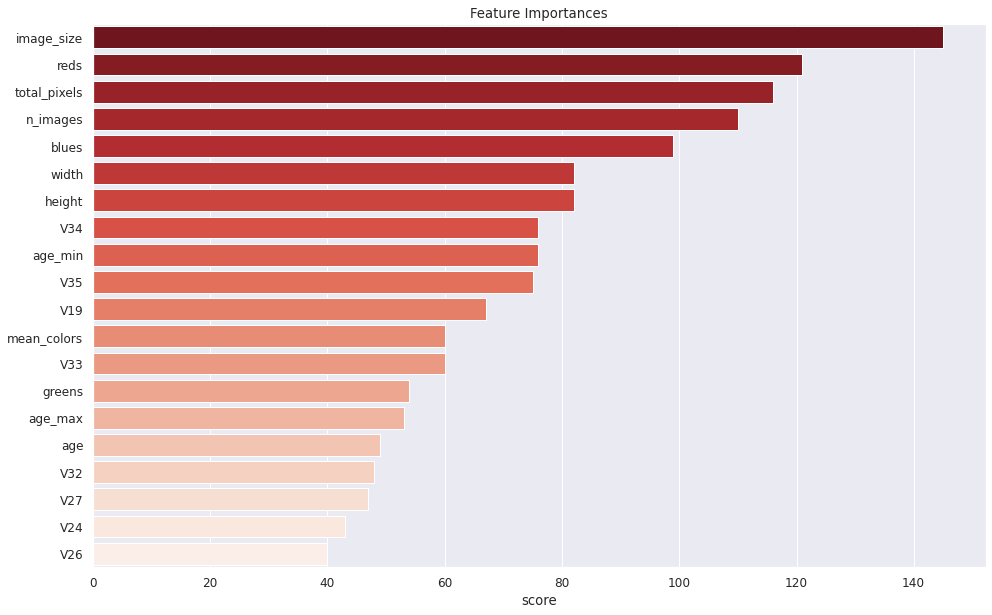

In [57]:
# finding feature importances and creating new dataframe basen on them

feature_importance = xg.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r')
ax.set_title('Feature Importances')
plt.show()

# First Step: Creating Meta Submission

In [58]:
# predicting on test set

predictions = xg.predict_proba(test)[:, 1]

In [59]:
# creating submission df


meta_df = pd.DataFrame(columns=['image_name', 'target'])

# assigning predictions on submission df

meta_df['image_name'] = sample['image_name']
meta_df['target'] = predictions

In [60]:
# creating submission csv file

meta_df.to_csv('meta_with_img_data.csv', header=True, index=False)


### The .csv file above scores ~85% on public LB but our inspections on train/test data shows it might be overfitting due to image differences, in next step we going try spot these features and make it little more robust...

# Adversarial Validation

Alright, since we have high doubts for train test sampling wanted to implement what is called 'Adversarial Validation'. For this we going to replace our targets for both datasets (0 for train and 1 for test), then we going build a classifier which tries to predict which observation belongs to train and which one belongs to test set. If datasets randomly selected from similar roots it should be really hard for the classifier to separate them. But if there is systematic selection differences between train and test sets then classifier should be able to capture this trend. So we want our models score lower for the next section because higher detection rate means higher difference between train and test datasets, so let's get started...


In [61]:
adv_train = train.copy()
adv_train.drop('target', axis=1, inplace=True)
adv_test = test.copy()

adv_train['dataset_label'] = 0
adv_test['dataset_label'] = 1

adv_master = pd.concat([adv_train, adv_test], axis=0)

adv_X = adv_master.drop('dataset_label', axis=1)
adv_y = adv_master['dataset_label']

In [62]:
adv_X_train, adv_X_test, adv_y_train, adv_y_test = train_test_split(adv_X,
                                                    adv_y,
                                                    test_size=0.4,
                                                    stratify=adv_y,
                                                    random_state=42)

In [63]:
xg_adv = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1,
)

# Fitting train data

xg_adv.fit(adv_X_train, adv_y_train)

# Predicting on holdout set
validation = xg_adv.predict_proba(adv_X_test)[:,1]

In [64]:
def plot_roc_feat(y_trues, y_preds, labels, est, x_max=1.0):
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax[0].plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax[0].legend()
    ax[0].grid()
    ax[0].plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax[0].set_title('ROC curve')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_xlim([-0.01, x_max])
    _ = ax[0].set_ylabel('True Positive Rate')
    
    
    feature_importance = est.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())

    importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)
    
    sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r', ax=ax[1])
    ax[1].set_title('Feature Importances')


## First Results

Well... It seems our model can seperate train and test set pretty good. This is not good, when we look at our ROC Curve it almost scores 90%, whe should dig this further... So to find the reason behind it we check our model's feature importances and we see image related features are really affecting it. So this confirms our findings in EDA part that train test sets are selected systematically to some degree... In next part we gonna drop some of these features to see if we can rebuild more robust model...

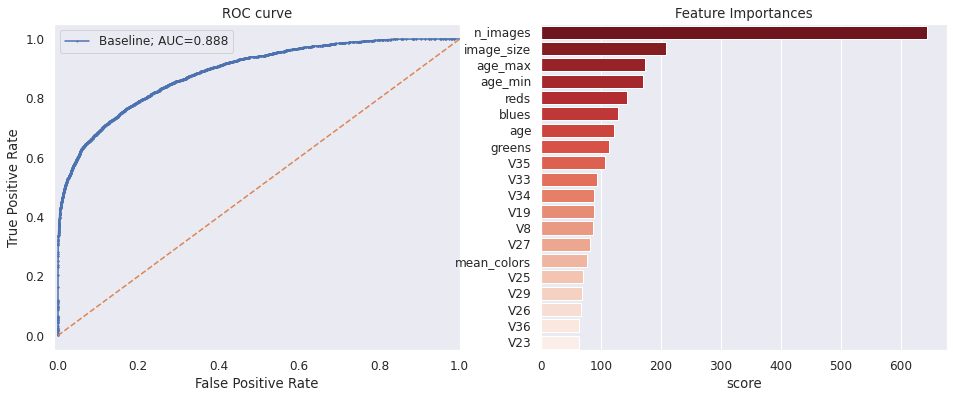

In [65]:
plot_roc_feat(
    [adv_y_test],
    [validation],
    ['Baseline'],
    xg_adv
)

## Let's drop image size and number related features to see if it's increase the randomness...

In [66]:
adv_X.drop(['n_images', 'image_size','width','height','total_pixels','reds','blues','greens','mean_colors', 'age_min', 'age_max'], axis=1, inplace=True)


adv_X_train, adv_X_test, adv_y_train, adv_y_test = train_test_split(adv_X,
                                                    adv_y,
                                                    test_size=0.4,
                                                    stratify=adv_y,
                                                    random_state=42)

# fitting train data

xg_adv.fit(adv_X_train, adv_y_train)

# predicting on holdout set
validation = xg_adv.predict_proba(adv_X_test)[:,1]

## Well yeah, it did! The more close our AUC 50% the better, so for now we can continue what we have for now.

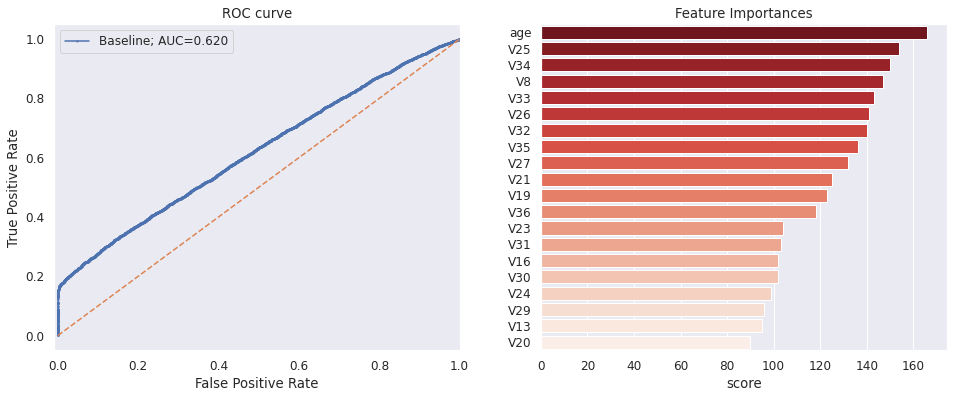

In [67]:
plot_roc_feat(
    [adv_y_test],
    [validation],
    ['Baseline'],
    xg_adv
)

In [68]:
X_train.drop(['n_images', 'image_size','width','height','total_pixels','reds','blues','greens','mean_colors', 'age_min', 'age_max'], axis=1, inplace=True)
#X_test.drop(['n_images', 'image_size','width','height','total_pixels','reds','blues','greens','mean_colors', 'age_min', 'age_max'], axis=1, inplace=True)

test.drop(['n_images', 'image_size','width','height','total_pixels','reds','blues','greens','mean_colors', 'age_min', 'age_max'], axis=1, inplace=True)

# Simplified Meta Predictions

We're going build our model with less biased features now. I wouldn't recommend submitting these predictions since you have limited submissions. These are for ensembling...

In [69]:
xg= xgb.XGBClassifier(
    n_estimators=750,
    learning_rate=0.015,
    min_child_weight= 218,
    max_delta_step= 4,
    max_depth= 2,
    subsample= 0.751,
    colsample_bytree= 0.77,
    gamma= 24,
    reg_lambda= 11,
    random_state=42,
    n_jobs=-1,
)

In [70]:
# display cv results

raw_models = model_check(X_train, y_train, [xg], cv)
display(raw_models)

,Model Name,Train roc Mean,Test roc Mean,Test Std,Time
0,XGBClassifier,0.717082,0.704358,0.012037,84.767264


In [71]:
# fitting train data

xg.fit(X_train, y_train)

predictions = xg.predict_proba(test)[:, 1]

meta_df = pd.DataFrame(columns=['image_name', 'target'])

# assigning predictions on submission df

meta_df['image_name'] = sample['image_name']
meta_df['target'] = predictions

# creating submission csv file

meta_df.to_csv('meta_simplified_img_data.csv', header=True, index=False)


# End of Tabular Data Part

### This simple approach including basic info as tabular data with good old ML algoithms gave me LB score of 0.8484! 

### Update: Since we spotted some important differences between train and test set I wanted to create less biased version of the meta .csv file so I added it here, it score less but would perform better on the ensembles you make...


# Machine Learning to Neural Networks

This part we gonna train more complicated models by using images themselves. For this part I was inspired by AgentAuers's 'Incredible TPUs' [here](https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once). It's a great notebook and you should check that, again thanks for AgentAuers for letting me use some of his code as baseline for this part of the notebook! Also thanks to Chris Deotte for great datasets with tfrecords! 

We start by importing neccesary packages and setting random seed.

In [72]:
# Importing packages

import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from kaggle_datasets import KaggleDatasets

tf.random.set_seed(seed_val)

In [73]:
# Loading image storage buckets

GCS_PATH = KaggleDatasets().get_gcs_path('melanoma-384x384')

filenames_train = np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec'))
filenames_test = np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec'))

In [74]:
# Setting TPU as main device for training, if you get warnings while working with tpu's ignore them.

DEVICE = 'TPU'
if DEVICE == 'TPU':
    print('connecting to TPU...')
    try:        
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print('Could not connect to TPU')
        tpu = None

    if tpu:
        try:
            print('Initializing  TPU...')
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print('TPU initialized')
        except _:
            print('Failed to initialize TPU!')
    else:
        DEVICE = 'GPU'

if DEVICE != 'TPU':
    print('Using default strategy for CPU and single GPU')
    strategy = tf.distribute.get_strategy()

if DEVICE == 'GPU':
    print('Num GPUs Available: ',
          len(tf.config.experimental.list_physical_devices('GPU')))

print('REPLICAS: ', strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
Initializing  TPU...
TPU initialized
REPLICAS:  8


Here we set config for our next steps. You can play with these but mind the memory sizes with the batches & image sizes.

In [75]:
# you can edit these settings.

cfg = dict(
           batch_size=32,
           img_size=384,
    
           lr_start=0.000005,
           lr_max=0.00000125,
           lr_min=0.000001,
           lr_rampup=5,
           lr_sustain=0,
           lr_decay=0.8,
           epochs=12,
    
           transform_prob=1.0,
           rot=180.0,
           shr=2.0,
           hzoom=8.0,
           wzoom=8.0,
           hshift=8.0,
           wshift=8.0,
    
           optimizer='adam',
           label_smooth_fac=0.05,
           tta_steps=20
            
        )

In [76]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift,
            width_shift):
    
    ''' Settings for image preparations '''

    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.

    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape(
        tf.concat([c1, s1, zero, -s1, c1, zero, zero, zero, one], axis=0),
        [3, 3])

    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(
        tf.concat([one, s2, zero, zero, c2, zero, zero, zero, one], axis=0),
        [3, 3])

    # ZOOM MATRIX
    zoom_matrix = tf.reshape(
        tf.concat([
            one / height_zoom, zero, zero, zero, one / width_zoom, zero, zero,
            zero, one
        ],
                  axis=0), [3, 3])

    # SHIFT MATRIX
    shift_matrix = tf.reshape(
        tf.concat(
            [one, zero, height_shift, zero, one, width_shift, zero, zero, one],
            axis=0), [3, 3])

    return K.dot(K.dot(rotation_matrix, shear_matrix),
                 K.dot(zoom_matrix, shift_matrix))


def transform(image, cfg):
    
    ''' This function takes input images of [: , :, 3] sizes and returns them as randomly rotated, sheared, shifted and zoomed. '''

    DIM = cfg['img_size']
    XDIM = DIM % 2  # fix for size 331

    rot = cfg['rot'] * tf.random.normal([1], dtype='float32')
    shr = cfg['shr'] * tf.random.normal([1], dtype='float32')
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['hzoom']
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['wzoom']
    h_shift = cfg['hshift'] * tf.random.normal([1], dtype='float32')
    w_shift = cfg['wshift'] * tf.random.normal([1], dtype='float32')

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot, shr, h_zoom, w_zoom, h_shift, w_shift)

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat(tf.range(DIM // 2, -DIM // 2, -1), DIM)
    y = tf.tile(tf.range(-DIM // 2, DIM // 2), [DIM])
    z = tf.ones([DIM * DIM], dtype='int32')
    idx = tf.stack([x, y, z])

    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM // 2 + XDIM + 1, DIM // 2)

    # FIND ORIGIN PIXEL VALUES
    idx3 = tf.stack([DIM // 2 - idx2[0, ], DIM // 2 - 1 + idx2[1, ]])
    d = tf.gather_nd(image, tf.transpose(idx3))

    return tf.reshape(d, [DIM, DIM, 3])

def prepare_image(img, cfg=None, augment=True):
    
    ''' This function loads the image, resizes it, casts a tensor to a new type float32 in our case, transforms it using the function just above, then applies the augmentations.'''
    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [cfg['img_size'], cfg['img_size']],
                          antialias=True)
    img = tf.cast(img, tf.float32) / 255.0

    if augment:
        if cfg['transform_prob'] > tf.random.uniform([1], minval=0, maxval=1):
            img = transform(img, cfg)

        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)

    return img

These functions below for reading labeled tfrecords.

In [77]:
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'patient_id': tf.io.FixedLenFeature([], tf.int64),
        'sex': tf.io.FixedLenFeature([], tf.int64),
        'age_approx': tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis': tf.io.FixedLenFeature([], tf.int64),
        'target': tf.io.FixedLenFeature([], tf.int64),
        #'width': tf.io.FixedLenFeature([], tf.int64),
        #'height': tf.io.FixedLenFeature([], tf.int64)
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'patient_id': tf.io.FixedLenFeature([], tf.int64),
        'sex': tf.io.FixedLenFeature([], tf.int64),
        'age_approx': tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    return example['image'], example['image_name']

def count_data_items(filenames):
    n = [
        int(re.compile(r'-([0-9]*)\.').search(filename).group(1))
        for filename in filenames
    ]
    return np.sum(n)

In [78]:
def getTrainDataset(files, cfg, augment=True, shuffle=True):
    
    ''' This function reads the tfrecord train images, shuffles them, apply augmentations to them and prepares the data for training. '''
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()

    if shuffle:
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    ds = ds.repeat()
    if shuffle:
        ds = ds.shuffle(2048)
    ds = ds.map(lambda img, label:
                (prepare_image(img, augment=augment, cfg=cfg), label),
                num_parallel_calls=AUTO)
    ds = ds.batch(cfg['batch_size'] * strategy.num_replicas_in_sync)
    ds = ds.prefetch(AUTO)
    return ds

def getTestDataset(files, cfg, augment=False, repeat=False):
    
    ''' This function reads the tfrecord test images and prepares the data for predicting. '''
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    if repeat:
        ds = ds.repeat()
    ds = ds.map(read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    ds = ds.map(lambda img, idnum:
                (prepare_image(img, augment=augment, cfg=cfg), idnum),
                num_parallel_calls=AUTO)
    ds = ds.batch(cfg['batch_size'] * strategy.num_replicas_in_sync)
    ds = ds.prefetch(AUTO)
    return ds

def get_model():
    
    ''' This function gets the layers inclunding efficientnet ones. '''
    
    model_input = tf.keras.Input(shape=(cfg['img_size'], cfg['img_size'], 3),
                                 name='img_input')

    dummy = tf.keras.layers.Lambda(lambda x: x)(model_input)

    outputs = []

    x = efn.EfficientNetB3(include_top=False,
                           weights='noisy-student',
                           input_shape=(cfg['img_size'], cfg['img_size'], 3),
                           pooling='avg')(dummy)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    outputs.append(x)

    x = efn.EfficientNetB4(include_top=False,
                           weights='noisy-student',
                           input_shape=(cfg['img_size'], cfg['img_size'], 3),
                           pooling='avg')(dummy)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    outputs.append(x)

    x = efn.EfficientNetB5(include_top=False,
                           weights='noisy-student',
                           input_shape=(cfg['img_size'], cfg['img_size'], 3),
                           pooling='avg')(dummy)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    outputs.append(x)

    model = tf.keras.Model(model_input, outputs, name='aNetwork')
    model.summary()
    return model

In [79]:
def compileNewModel(cfg):
    
    ''' Configuring the model with losses and metrics. '''    
    
    with strategy.scope():
        model = get_model()

    with strategy.scope():
        model.compile(optimizer=cfg['optimizer'],
                      loss=[
                          tf.keras.losses.BinaryCrossentropy(
                              label_smoothing=cfg['label_smooth_fac']),
                          tf.keras.losses.BinaryCrossentropy(
                              label_smoothing=cfg['label_smooth_fac']),
                          tf.keras.losses.BinaryCrossentropy(
                              label_smoothing=cfg['label_smooth_fac'])
                      ],
                      metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

def getLearnRateCallback(cfg):
    
    ''' Using callbacks for learning rate adjustments. '''
    
    lr_start = cfg['lr_start']
    lr_max = cfg['lr_max'] * strategy.num_replicas_in_sync * cfg['batch_size']
    lr_min = cfg['lr_min']
    lr_rampup = cfg['lr_rampup']
    lr_sustain = cfg['lr_sustain']
    lr_decay = cfg['lr_decay']

    def lrfn(epoch):
        if epoch < lr_rampup:
            lr = (lr_max - lr_start) / lr_rampup * epoch + lr_start
        elif epoch < lr_rampup + lr_sustain:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_rampup -
                                                lr_sustain) + lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

def learnModel(model, ds_train, stepsTrain, cfg, ds_val=None, stepsVal=0):
    
    ''' Fitting things together for training '''
    
    callbacks = [getLearnRateCallback(cfg)]

    history = model.fit(ds_train,
                        validation_data=ds_val,
                        verbose=1,
                        steps_per_epoch=stepsTrain,
                        validation_steps=stepsVal,
                        epochs=cfg['epochs'],
                        callbacks=callbacks)

    return history

Here we train our model, takes a while but at the end we'll have strong model to make predictions!

In [80]:
# getting train data

ds_train = getTrainDataset(
    filenames_train, cfg).map(lambda img, label: (img, (label, label, label)))
stepsTrain = count_data_items(filenames_train) / \
    (cfg['batch_size'] * strategy.num_replicas_in_sync)

# compiling and training model

model = compileNewModel(cfg)
learnModel(model, ds_train, stepsTrain, cfg)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f4e05d6f8c0>. It was defined on this line: filenames_train, cfg, which must contain a single lambda with matching signature. To avoid ambiguity, define each lambda in a separate expression.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
115261440/115255328 [==============================] - 4s 0us/step
Model: "aNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 384, 384, 3) 0                                            
____________________________________________________________________________________________

Here we make predictions using the model we trained. Then we blend them for each EffNet by taking mean. We create csv file for each prediction including blended one.

In [81]:
steps = count_data_items(filenames_test) / \
    (cfg['batch_size'] * strategy.num_replicas_in_sync)

z = np.zeros((cfg['batch_size'] * strategy.num_replicas_in_sync))

# loading test data

ds_testAug = getTestDataset(
    filenames_test, cfg, augment=True,
    repeat=True).map(lambda img, label: (img, (z, z, z)))

# test time augmentations for predictions (20 in our case, you can increase it a little in cfg) and taking mean of them

probs = model.predict(ds_testAug, verbose=1, steps=steps * cfg['tta_steps'])
probs = np.stack(probs)
probs = probs[:, :count_data_items(filenames_test) * cfg['tta_steps']]
probs = np.stack(np.split(probs, cfg['tta_steps'], axis=1), axis=1)
probs = np.mean(probs, axis=1)

test = pd.read_csv(os.path.join(base_path, 'test.csv'))

y_test_sorted = np.zeros((3, probs.shape[1]))
test = test.reset_index()
test = test.set_index('image_name')

i = 0
ds_test = getTestDataset(filenames_test, cfg)
for img, imgid in tqdm(iter(ds_test.unbatch())):
    imgid = imgid.numpy().decode('utf-8')
    y_test_sorted[:, test.loc[imgid]['index']] = probs[:, i, 0]
    i += 1

    
# creating .csv files for each effnet
    
for i in range(y_test_sorted.shape[0]):
    submission = sample
    submission['target'] = y_test_sorted[i]
    submission.to_csv('submission_model_%s.csv' % i, index=False)

# blending effnets into a single .csv file    

submission = sample
submission['target'] = np.mean(y_test_sorted, axis=0)
submission.to_csv('blended_effnets.csv', index=False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f4d215c9680>. It was defined on this line: repeat=True, which must contain a single lambda with matching signature. To avoid ambiguity, define each lambda in a separate expression.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
858/857 [==============================] - 302s 352ms/step


10982it [00:28, 382.24it/s]


# Ensembling With Meta

Here's the last step. We'll use our blended predictions created by training images and simply metadata created by using tabular data. We ensemble them together with weights and make our final predictions. Feel free to experiment with ensembling. This basic blending increased my LB score a little, you can change lots of things in previous steps to do some experiments, it's fun!

In [82]:
# loading recently created .csv files from working directory

effnet = pd.read_csv('./blended_effnets.csv')
meta = pd.read_csv('./meta_simplified_img_data.csv')


sample['target'] = (
                           
                           effnet['target'] * 0.9 +
                           meta['target'] * 0.1 
                          
                          )

# final submissions

sample.to_csv('ensembled.csv', header=True, index=False)

# Submission and Some Notes

Again I wanted to thank to kaggle community for inspiring me for this approach. I'm still learning and working on these notebooks helping me a lot, I hope these can be helpful you too! About the notebook itself next step would be implementing a cross validation scheme and test your predictions on it, if you find sweet spot that both increases your CV and LB scores then you are on the right track! But I'll leave this notebook here for now, thank you all for reading!

In [83]:
sample.head()

,image_name,target
0,ISIC_0052060,0.027438
1,ISIC_0052349,0.026074
2,ISIC_0058510,0.025925
3,ISIC_0073313,0.026442
4,ISIC_0073502,0.033966




<div align='center'><font size='6' color='#000000'>Final Words</font></div>

<hr>

<div align='center'><font size='4' color='#000000'>This notebook still in progress and if you have any feedbacks please leave me a comment I'll be reading them for sure and if you liked my work please don't forget to leave an upvote. Thank you for reading!</font></div>

<hr>

## Update: Added new notebook here using our EffNet predictions here and ensembling them with external tabular data including extra malignant examples. You can find it here [Analysis of External and Upsampled Metadata for SIIM-ISIC Melanoma Classification](https://www.kaggle.com/datafan07/eda-modelling-of-the-external-data-inc-ensemble). Happy coding all!